# SpecUFEx Tutorial: Amatrice, Italy October 2016

Written by Theresa Sawi and Nate Groebner


This example walks through fitting a SpecUFEx$^0$ model to seismograms of approximately 1,000 earthquakes from the first 6 days of the October 2016 Amatrice (Italy) earthquake sequence. This is a subset of the events detected via Quakeflow$^1$ (PhaseNet$^2$  + Gamma$^3$  + HypoInverse$^4$ + HypoDD$^5$) by Kaiwen Wang and Felix Waldhauser. We cluster the features extracted by SpecUFEx with K-means clustering to identify patterns of earthquakes. 


## We've color coded the markdown cells in this notebook to indicate where you can edit the code cells: 

<div class="alert-success">
    
## Example. Feel free to the cell below this box
   
</div>






## Tutorial Steps


1. Read in waveforms from hdf5 file. These are 20-second records from a short-period seismograph filtered between 1-40 Hz, windowed 3 seconds before and 17 seconds after the P-wave picks on the vertical component from station IV.T1412, which is located roughly in the middle of the earthquake sequence.
2. Convert waveforms to spectrograms (filtered and median normalized). 
3. Run SpecUFEx on spectrograms
4. K-means clustering on SpecUFEx fingerprints (evaluated using Silhouette scores)
5. View spatial and magnitude trends of the clusters


## Publications

See recent publications featuring SpecUFEx:

1. Sawi, T., Waldhauser, F., Holtzman, B., Groebner N. (2023) Detecting repeating earthquakes on the San Andreas Fault with unsupervised machine-learning of spectrograms. The Seismic Record; 3 (4): 376–384. [Link](https://doi.org/10.1785/0320230033)
2. Sawi, T., Holtzman, B., Walter, F., & Paisley, J. (2022) An unsupervised machine-learning approach to understanding seismicity at an alpine glacier. Journal of Geophysical Research: Earth Surface, 127, e2022JF006909. [Link](https://doi.org/10.1029/2022JF006909)





## References

0. Holtzman, B. K., Paté, A., Paisley, J., Waldhauser, F., & Repetto, D. (2018). Machine learning reveals cyclic changes in seismic source spectra in Geysers geothermal field. Science Advances, 4, 5. https://doi.org/10.1126/sciadv.aao2929
1. Zhu, W., Hou, A. B., Yang, R., Datta, A., Mostafa Mousavi, S., Ellsworth, W. L., & Beroza, G. C. (2023). QuakeFlow: a scalable machine-learning-based earthquake monitoring workflow with cloud computing. Geophysical Journal International, 232(1), 684–693. https://doi.org/10.1093/gji/ggac355
2. Zhu, W., & Beroza, G. C. (2018). PhaseNet: A Deep-Neural-Network-Based Seismic Arrival Time Picking Method. Geophysical Journal International, 216(1), 261–273. https://doi.org/10.1093/gji/ggy423
3.  Zhu, W., McBrearty, I. W., Mousavi, S. M., Ellsworth, W. L., & Beroza, G. C. (2022). Earthquake phase association using a Bayesian Gaussian Mixture Model. Journal of Geophysical Research: Solid Earth, 127, e2021JB023249. https://doi.org/10.1029/2021JB023249 
4. Klein, F. W. (2002). User’s guide to HYPOINVERSE-2000, a Fortran program to solve for earthquake locations and magnitudes. In Open-File Report. https://doi.org/10.3133/ofr02171
5. Waldhauser, F., HypoDD: A computer program to compute double-difference earthquake locations, USGS Open File Rep., 01-113, 2001. pdf




### Imports

In [10]:
import time
import datetime
from datetime import datetime
import glob
import os
import h5py
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import scipy.signal as sp
from sklearn.cluster import KMeans
from tqdm import trange
import obspy
from specufex import BayesianNonparametricNMF, BayesianHMM
import tqdm
from sklearn.metrics import silhouette_samples
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

np.random.seed(42)

## Define helper functions




1. ```calcSilhScore:```   Calculates the optimal number of clusters and silhouette scores for K-means clustering based on user-defined range of clusters
2. ```getSgram```         Get spectrogram from H5 file based on event ID


In [8]:




def calcSilhScore(X,range_n_clusters=np.arange(2,11)):
    """
    Calculates the optimal number of clusters and silhouette scores for K-means clustering.

    Parameters:
    -----------
    X : array-like
        The input dataset to be clustered.
    range_n_clusters : list or range
        A range of integers specifying the number of clusters to evaluate.

    Returns:
    --------

    ## Return avg silh scores, avg SSEs, and Kopt for 2:Kmax clusters
    ## Returns altered cat00 dataframe with cluster labels and SS scores,
    ## Returns NEW catall dataframe with highest SS scores

    Kopt : int
        The optimal number of clusters.
    maxSilScore : float
        The maximum silhouette score achieved.
    avgSils : list
        A list of average silhouette scores for each number of clusters.
    sse : list
        A list of sum of squared errors for each number of clusters.
    cluster_labels_best : array-like
        cluster labels for the best clustering result.
    ss_best : array-like
        Silhouette scores for each sample in the best clustering result.
    euc_dist_best : array-like
        Euclidean distances to the centroids for each sample in the best clustering result.
    """

    maxSilScore = 0

    sse = []
    avgSils = []
    centers = []

    for n_clusters in range_n_clusters:

        print(f"kmeans on {n_clusters} clusters...")

        kmeans = KMeans(n_clusters=n_clusters,
                           max_iter = 500,
                           init='k-means++', #how to choose init. centroid
                           n_init=10, #number of Kmeans runs
                           random_state=0) #set rand state

        #get cluster labels
        cluster_labels_0 = kmeans.fit_predict(X)

        #increment labels by one to match John's old kmeans code
        cluster_labels = [int(ccl)+1 for ccl in cluster_labels_0]

        #get euclid dist to centroid for each point
        sqr_dist = kmeans.transform(X)**2 #transform X to cluster-distance space.
        sum_sqr_dist = sqr_dist.sum(axis=1)
        euc_dist = np.sqrt(sum_sqr_dist)

        #save centroids
        centers.append(kmeans.cluster_centers_ )

        #kmeans loss function
        sse.append(kmeans.inertia_)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

#         %  Silhouette avg
        avgSil = np.mean(sample_silhouette_values)

        # avgSil = np.median(sample_silhouette_values)

        avgSils.append(avgSil)
        if avgSil > maxSilScore:
            Kopt = n_clusters
            maxSilScore = avgSil
            cluster_labels_best = cluster_labels
            euc_dist_best = euc_dist
            ss_best       = sample_silhouette_values


    print(f"Best cluster: {Kopt}")



    return Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best


def getSgram(evID,SpecUFEx_H5_path):

    '''
    Get spectrogram from H5 file based on event ID
    '''
    with h5py.File(SpecUFEx_H5_path,'r') as fileLoad:

        sgram = fileLoad['spectrograms'].get(str(evID))[:]
        fSTFT = fileLoad['spectrograms/fSTFT'][()]
        tSTFT = fileLoad['spectrograms/tSTFT'][()]
       
    
    return tSTFT, fSTFT, sgram




<div class="alert-success">

# Definitions and parameters

Here, we define station location, file paths, as well as spectrogram-generation, SpecUFEx, and clustering parameters. 


### Guidelines for spectrogram parameters:

#### Bandpass filter for spectrogram (optional)
fMin = 5  # Hz
    
fMax = 20  # Hz

    
    
#### Spectrogram parameters
sgramMode = 'magnitude' # returns absolute magnitude of the STFT 
    
sgramScaling = 'spectrum' # calculate power spectrum where Sxx has units of V**2, if x is measured in V and fs is measured in Hz


    
    
#### Frequency/time resolution
nperseg = 64 # Length of each segment in samples
    
noverlap = nperseg / 4 #Number of samples to overlap between segments
    
nfft = 512 # Length of the FFT used in samples, if a zero padded FFT is desired. If None, the FFT length is nperseg. Defaults to None.



</div>

In [13]:
########################################################################
### Station lat and lon (for plotting)
########################################################################

station_lon, station_lat = 13.208697, 42.759537


########################################################################
### Directory paths (don't edit for tutorial)
########################################################################

# Path to load waveforms H5, downloaded in next cell
wf_H5_path = "./data/amatrice/waveforms_respremoved_1000.h5"

# Path to save spectrograms and SpecUFEx output
SpecUFEx_H5_path = './data/amatrice/SpecUFEx_waveforms_respremoved_1000.h5'

########################################################################
### Spectrogram Parameters (edit with caution)
########################################################################


# Bandpass filter for spectrogram (optional)
fMin = 5  # Hz
fMax = 20  # Hz

# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html for more information about spectrogram parameters.

# Spectrogram settings
sgramMode = 'magnitude' # returns absolute magnitude of the STFT 
sgramScaling = 'spectrum' # calculate power spectrum where Sxx has units of V**2, if x is measured in V and fs is measured in Hz

# Time resolution for FFT
nperseg = 64 # Length of each segment in samples
noverlap = nperseg / 4 #Number of samples to overlap between segments
nfft = 512 # Length of the FFT used in samples, if a zero padded FFT is desired. If None, the FFT length is nperseg. Defaults to None.

########################################################################
### SpecUFEx Parameters (edit with caution)
########################################################################

### Nonnegative matrix factorization
num_pat = 75  # Initial number of spectral patterns to learn; will shrink to fit data set so can set arbitrarily high
batches_nmf = 1000 # number of batches for stochastic variational inference (can set higher)
batch_size_nmf = 1 # batch size

num_states = 15  # HMM
batches_hmm = 1000 # number of batches for stochastic variational inference (can set higher)
batch_size_hmm = 1 # batch size

########################################################################
### Clustering Parameters (see lower down in notebook)
########################################################################

# Number of examples from each cluster to view
numEx = 10

### Moved down in notebook for tutorial 
# min_num_cluster = 3 # minimum number of clusters for K-means (minimum = 1)
# max_num_cluster = 20 #  maximum number of clusters for K-means

## Download HDF5

HDF5 is a data format that is structured like a classic file directory, where strings or numeric datasets can be stored and accessed in a hierarchy of folders called "groups".
For the purposes of this tutorial, we have pre-constructed the waveforms HDF5 file and loaded it online for you to download in the cell below. To make your own waveform HDF5 file, see the notebook in tutorials/amatrice_makeH5.ipynb. For more information on the HDF5 format, see [https://www.hdfgroup.org/solutions/hdf5/](https://www.hdfgroup.org/solutions/hdf5/).

In [5]:
# download waveforms H5 file

time0 = time.time()
! curl -O "https://www.ldeo.columbia.edu/~felixw/SCOPED/waveforms_respremoved_1000.h5" 
! mv waveforms_respremoved_1000.h5 data/amatrice/
time1 = time.time()
time2 = time1-time0
print(f"\n {time2:.2f} seconds elapsed")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.1M  100 19.1M    0     0  1236k      0  0:00:15  0:00:15 --:--:-- 1343k94k

 16.16 seconds elapsed


## Load H5

Below is the file structure for the waveform HDF5 file we just loaded:


- waveforms_respremoved_1000.h5


    - waveforms            # Waveform data
    - event_ids             # Event IDs
    - otime                # Origin time (UTC)
    - lat                  # Event origin latitude
    - lon                  # Event origin longitude
    - mag                  # Event magnitude
    - depth                # Event depth
    - fs                   # Hz, sampling rate


In [5]:
with h5py.File(wf_H5_path, "r") as h5fi:


    waveforms = h5fi["waveform"][()] # Waveform data
    event_ids = h5fi["event_ID"][()] # Event IDs
    otime = h5fi["otime"][()]  # Origin time
    lat = h5fi["lat"][()] # dataset of event IDs
    lon = h5fi["lon"][()] # dataset of event IDs
    mag = h5fi["mag"][()] # dataset of event IDs    
    depth = h5fi["depth"][()]  # dataset of event IDs   
    fs = h5fi["sampling_rate"][()]  # Hz, sampling rate

    
  


## We build a pandas DataFrame object as our earthquake event catalog:

In [6]:
#Buid catalog from H5 file

cat = pd.DataFrame({'event_ID':event_ids,
                    'lat':lat,
                    'lon':lon,
                    'depth':depth,
                    'mag':mag,                    
                    'otime': otime})

cat['event_ID'] = [f.decode('utf-8') for f in cat['event_ID']] # convert string from bytes to UTF-8 format


cat['otime'] = [datetime.strptime(f.decode('utf-8'), '%Y-%m-%d %H:%M:%S.%f') for f in cat['otime']] # convert string to datetime
cat['waveform'] = list(waveforms)

cat.head()

,event_ID,lat,lon,depth,mag,otime,waveform
0,100002,42.7523,13.1802,3.04,-0.78,2016-10-13 00:00:06.340,"[4.2243607469401114e-10, 4.062518283745035e-10..."
1,100007,42.8697,13.0733,1.82,0.32,2016-10-13 00:01:34.430,"[-4.161164062285241e-10, -4.3308143399426666e-..."
2,100008,42.6430,13.2463,8.08,-0.31,2016-10-13 00:02:23.000,"[8.48574001873357e-10, 5.627940091035957e-11, ..."
3,100037,42.8095,13.2003,3.57,-0.22,2016-10-13 00:13:51.200,"[3.980581446535858e-09, -2.4276266300034087e-0..."
4,100044,42.6847,13.2170,7.88,0.05,2016-10-13 00:15:53.610,"[-3.0818493229896635e-09, 2.1899228617786262e-..."
...,...,...,...,...,...,...,...
991,116395,42.8197,13.1870,2.82,-0.14,2016-10-18 23:16:06.170,"[8.848656920023287e-09, -7.835544594781829e-11..."
992,116400,42.8067,13.0865,5.50,0.04,2016-10-18 23:17:57.580,"[8.844901005002873e-09, 1.606260378612245e-08,..."
993,116439,42.8502,13.1568,4.40,0.03,2016-10-18 23:34:15.060,"[7.398350205050709e-09, 2.373064627032571e-09,..."
994,116445,42.8243,13.0503,3.32,-0.13,2016-10-18 23:36:16.650,"[1.4101517337333794e-09, 2.993863540435694e-08..."


# Create spectrograms



### Calculate spectrograms and convert to dB

The NMF algorithm requires that all spectrograms contain nonnegative values. The following procedure normalizes each spectrogram individually and ensures element-wise nonnegativity.

Calculate raw spectrograms using scipy:

In [8]:
# Length of waveform data (must all be the same length)
len_data = len(cat["waveform"].iloc[0])


fSTFT, tSTFT, STFT_raw = sp.spectrogram(
    x=np.stack(cat["waveform"].values),  # Input signal
    fs=fs,                                # Sampling frequency (Hz)
    nperseg=nperseg,                      # Length of each segment (in samples)
    noverlap=noverlap,                    # Number of points to overlap between segments
    nfft=nfft,                            # Length of the FFT window
    scaling=sgramScaling,                 # Type of scaling to apply
    axis=-1,                              # Axis along which the spectrogram is computed
    mode=sgramMode                        # Mode of the spectrogram computation
)


Quality check to see if any elements are NaN.

In [9]:
np.isnan(STFT_raw).any()

False

*Optional step*: Select a frequency band from the spectrograms

Some applications benefit from discarding low and/or high frequency data from the spectrograms, e.g. if there is significant high frequency noise. The following applies a bandpass filter to the data in the frequency domain.

In [10]:
freq_slice = np.where((fSTFT >= fMin) & (fSTFT <= fMax))
fSTFT   = fSTFT[freq_slice]
STFT_0 = STFT_raw[:,freq_slice,:].squeeze()

Next, we normalize each spectrogram by its median and convert to dB. This creates a matrix where about half of the nonzero entries are negative and half are positive. All of the negative entries are then set to zero, ensuring that the NMF algorithm has valid, nonnegative data. It also has the effect of throwing away half of the data, the half that is below the median dB value. 

In [11]:
normConstant = np.median(STFT_0, axis=(1,2))
STFT_norm = STFT_0 / normConstant[:,np.newaxis,np.newaxis]  # norm by median
del STFT_0
STFT_dB = 20*np.log10(STFT_norm, where=STFT_norm != 0) # convert to dB
del STFT_norm
STFT = np.maximum(0, STFT_dB) # make sure nonnegative
del STFT_dB

cat["stft"] = list(STFT)
cat.head()

,event_ID,lat,lon,depth,mag,otime,waveform,stft
0,100002,42.7523,13.1802,3.04,-0.78,2016-10-13 00:00:06.340,"[4.2243607469401114e-10, 4.062518283745035e-10...","[[4.82617167750785, 0.0, 0.0, 0.0, 2.451006879..."
1,100007,42.8697,13.0733,1.82,0.32,2016-10-13 00:01:34.430,"[-4.161164062285241e-10, -4.3308143399426666e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,100008,42.6430,13.2463,8.08,-0.31,2016-10-13 00:02:23.000,"[8.48574001873357e-10, 5.627940091035957e-11, ...","[[0.39380922199889445, 4.536511501270216, 4.42..."
3,100037,42.8095,13.2003,3.57,-0.22,2016-10-13 00:13:51.200,"[3.980581446535858e-09, -2.4276266300034087e-0...","[[2.0045813306918308, 0.6775345700161346, 0.0,..."
4,100044,42.6847,13.2170,7.88,0.05,2016-10-13 00:15:53.610,"[-3.0818493229896635e-09, 2.1899228617786262e-...","[[0.0, 0.0, 1.9642720816366577, 0.0, 0.0, 0.0,..."


Another quality check.

In [12]:
bad_idx = cat["stft"][cat["stft"].apply(lambda x: np.isnan(x).any())].index
print(f"Bad spectrograms: \n{cat.loc[bad_idx].event_ID}")
cat = cat.drop(bad_idx).sort_values("event_ID")

Bad spectrograms: 
Series([], Name: event_ID, dtype: object)


<div class="alert-success">

#### Plotted below is a raw spectrogram and its normalized counterpart. 
    
Notice how the overall dynamic range of spectrogram is compressed.
    
    
Change ```n_spectrogram = 0``` to a different index number to see different spectrograms (and later, fingerprints)



</div>



Text(0.5, 1.0, 'Normalized spectrogram')

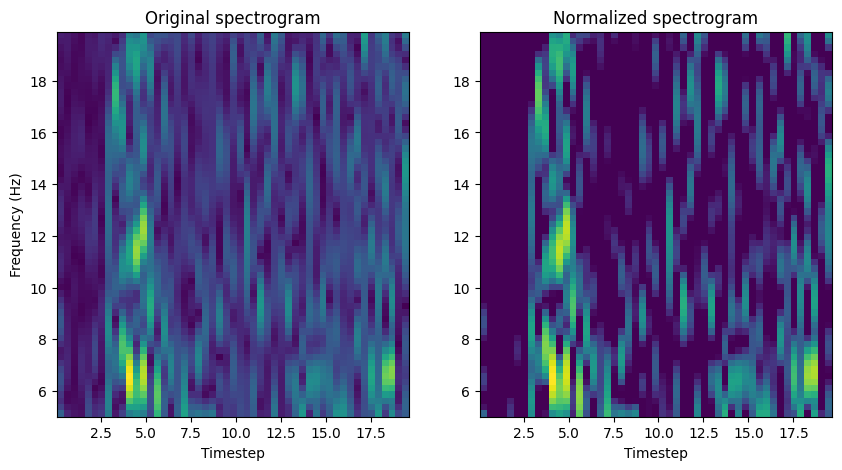

In [13]:
n_spectrogram = 0 # index of spectrogram to plot




########################################################################
## don't edit below this line
########################################################################
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].pcolormesh(tSTFT,fSTFT,STFT_raw[n_spectrogram,freq_slice,:].squeeze())
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Frequency (Hz)")
ax[0].set_title("Original spectrogram")

ax[1].pcolormesh(tSTFT,fSTFT, STFT[n_spectrogram])
ax[1].set_xlabel("Timestep")
ax[1].set_title("Normalized spectrogram")


# Run specufex

## Fitting models and transforming data

SpecUFEx fits a group of spectrograms, where D is the number of rows (frequency bands) and M is the number of columns (timesteps) in each spectrogram. The spectrograms must be in a numpy-compatible matrix of dimension, N being the number of spectrograms in the dataset. Each spectrogram must consist of all nonnegative (>=0) entries

The two main classes in this package are `BayesianNonparametricNMF` and `BayesianHMM`. Each has fit, transform, and fit_transform methods to be consistent with the Scikit-learn API style.

### Probabilistic nonegative matrix factorization

The first step in the specufex algorithm is to decompose the set of spectrograms into a single, common "dictionary" matrix and a set of "activation matrices", one for each spectrogram. The `BayesianNonParametricNMF` class implements a probabilistic hierarchical Bayesian model for estimating this decomposition.

First instantiate the nmf model. The constructor takes a tuple with the dimensions of the spectrogram matrix.

In [14]:

nmf = BayesianNonparametricNMF(np.stack(cat["stft"].values).shape, num_pat=num_pat)



The model is fit in a loop. In our case, we use 100,000 batches with batch size of 1.

In [15]:

time0 = time.time()

t = trange(batches_nmf, desc="NMF fit progress ", leave=True)
for i in t:
    idx = np.random.randint(len(cat["stft"].values), size=batch_size_nmf)
    nmf.fit(cat["stft"].iloc[idx].values)
    t.set_postfix_str(f"Patterns: {nmf.num_pat}")

time1 = time.time()
time2 = time1-time0
print(f"\n {time2:.2f} seconds elapsed")

NMF fit progress : 100%|██████| 1000/1000 [00:16<00:00, 61.70it/s, Patterns: 13]


 16.23 seconds elapsed


The estimated dictionary matrix is plotted below.

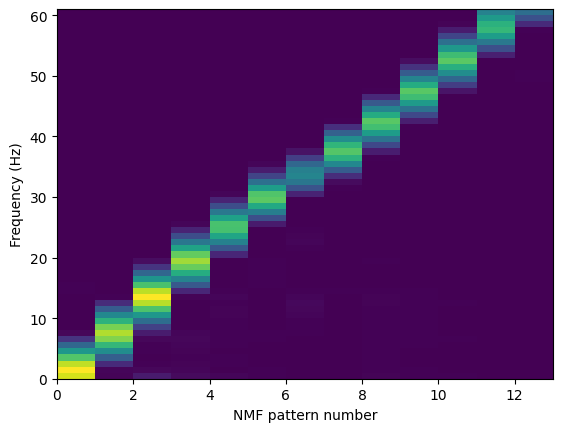

In [16]:
plt.pcolormesh(nmf.EW@np.diag(nmf.EA[0]))
plt.xlabel("NMF pattern number")
plt.xticks(range(0,nmf.num_pat,2), range(0,nmf.num_pat,2))
plt.ylabel("Frequency (Hz)")
plt.show()

Next, the `transform` method of the` BayesianNonparametricNMF` class is used to find the activation matrices, Vs, for each spectrogram.

In [17]:
Vs = nmf.transform(cat["stft"].values)
# save Vs to an hdf5
with h5py.File("data/geysers/Vs.h5", "w") as f:
    f["Vs"] = Vs


Here is an example activation matrix, plotted with the corresponding original normalized matrix.

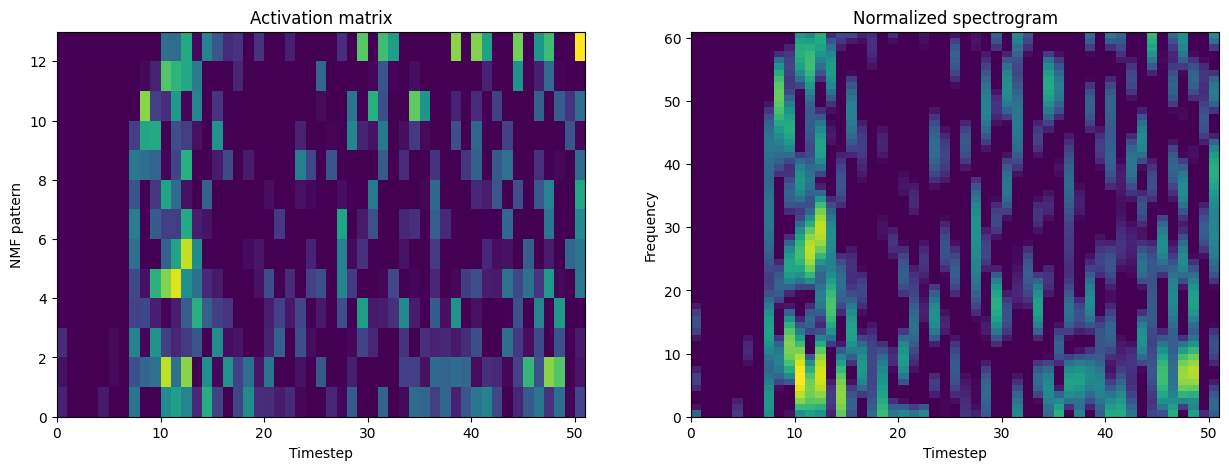

In [18]:
f, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].pcolormesh(Vs[n_spectrogram])
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("NMF pattern")
axes[0].set_yticks(range(0,nmf.num_pat,2), range(0,nmf.num_pat,2))
axes[0].set_title("Activation matrix")

axes[1].pcolormesh(cat["stft"].iloc[n_spectrogram])
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Normalized spectrogram")

plt.show()

### Probabilistic Hidden Markov Model

A hidden Markov model describes a system where a sequence of observations is produced by hidden, or unobservable, states. In our case, the frequency components of each timestep in a spectrogram is assumed to be emitted with a particular probability by one of the hidden states. The code fits an HMM model to the spectrograms, and for each timestep calculates the most probable hidden state that produced the frequency pattern.

The HMM model is created using the `BayesianHMM` class. Currently, in order to setup the object correctly the number of NMF patterns (num_pat) and the gain calculated by `BayesianNonparametricNMF` are passed to the constructor. Similar to the NMF calculation, the data are transformed to fingerprints with the transform function.

In [19]:
#nmf = BayesianNonparametricNMF.load("data/geysers/nmf.h5")

hmm = BayesianHMM(nmf.num_pat, nmf.gain, num_state=num_states, Neff=1000)

In [21]:
time0 = time.time()

t = trange(batches_hmm, desc="HMM fit progress ", leave=True)
for i in t:
    idx = np.random.randint(Vs.shape[0], size=batch_size_hmm)
    hmm.fit(Vs[idx])

time1 = time.time()
time2 = time1-time0
print(f"\n {time2:.2f} seconds elapsed")

HMM fit progress : 100%|████████████████████| 1000/1000 [00:46<00:00, 21.55it/s]


 46.41 seconds elapsed


The *emmission matrix* of the HMM relates the hidden state to the expected value of each frequency emitted by that state. Below is the calculated emmissions matrix for our model.

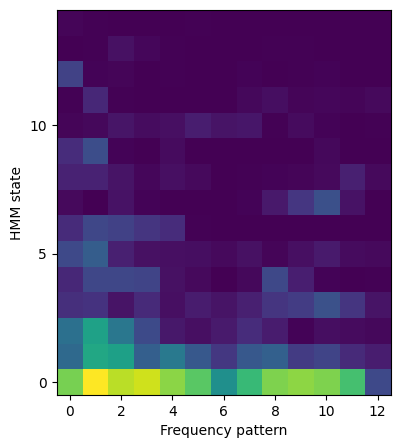

In [22]:
plt.figure(figsize=(10,5))
plt.imshow(hmm.EB, origin="lower")
plt.ylabel("HMM state")
plt.xlabel("Frequency pattern")
_=plt.yticks(range(0,num_states,5), range(0, num_states,5))

Next step is to calculate the "fingerprints", which are the final features calculated by the SpecUFEx algorithm. ?The fingerprints are a statistical representation of how likely each state transition is for each individual spectrogram.

Below, the `.transform()` method is used to calculate the fingerprints. It also returns a state transition count matrix (`As`) and the state sequence matrix (`gams`).

In [23]:
time1 = time.time()

fingerprints, As, gams = hmm.transform(Vs)

time1 = time.time()
time2 = time1-time0
print(f"\n {time2:.2f} seconds elapsed")


 84.86 seconds elapsed


And this is the state transition matrix. This is the actual temporal order of probabilities that the system was in a given state when it emitted the frequencies.


In [ ]:
plt.pcolormesh(gams[n_spectrogram])
plt.xlabel("Time step")
plt.ylabel("Hidden State")
plt.show()

Example of a fingerprint. Each entry in the matrix is the probability that, for the corresponding spectrogram, a given state transitions to another state.

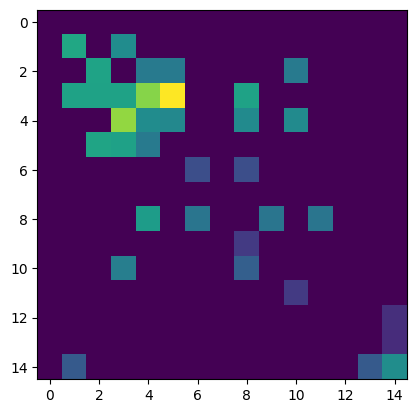

In [24]:
plt.imshow(fingerprints[n_spectrogram])

# Save spectrograms and SpecuFEx output, and parameters, to H5


In [26]:

####################################################################################
####################################################################################
###
### save output to H5 (don't edit)
###
####################################################################################
####################################################################################


print('writing all output to h5')
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:


    ##fingerprints are top folder
    if 'fingerprints' in fileLoad.keys():
        del fileLoad["fingerprints"]
    fp_group = fileLoad.create_group('fingerprints')

    if 'SpecUFEX_output' in fileLoad.keys():
        del fileLoad["SpecUFEX_output"]
    out_group = fileLoad.create_group("SpecUFEX_output")

    if 'spectrograms' in fileLoad.keys():
        del fileLoad["spectrograms"]
    sp_group = fileLoad.create_group("spectrograms")    

    
    # write fingerprints: ===============================
    for i, evID in enumerate(cat.event_ID):
        fp_group.create_dataset(name= evID, data=fingerprints[i])

    # write the spectrograms: ===========================    
    
    for i, evID in enumerate(cat.event_ID):
        sp_group.create_dataset(name= evID, data=cat["stft"].iloc[i])

    sp_group.create_dataset(name='fSTFT',data=fSTFT)
    sp_group.create_dataset(name='tSTFT',data=tSTFT)
    sp_group.create_dataset(name='nperseg',data=nperseg)
    sp_group.create_dataset(name='noverlap',data=noverlap)
    sp_group.create_dataset(name='nfft',data=nfft)
    sp_group.create_dataset(name='sgramScaling',data=sgramScaling)
    sp_group.create_dataset(name='sgramMode',data=sgramMode)

    # write the SpecUFEx out: ===========================
    # maybe include these, but they are not yet tested.
    ACM_group = fileLoad.create_group("SpecUFEX_output/ACM")
    STM_group = fileLoad.create_group("SpecUFEX_output/STM")

    for i, evID in enumerate(cat.event_ID):
        ACM_group.create_dataset(name=evID,data=Vs[i]) #ACM
        STM_group.create_dataset(name=evID,data=gams[i]) #STM

    gain_group = fileLoad.create_group("SpecUFEX_output/ACM_gain")
    W_group                      = fileLoad.create_group("SpecUFEX_output/W")
    EB_group                     = fileLoad.create_group("SpecUFEX_output/EB")
    ## # # delete probably ! gain_group                   = fileLoad.create_group("SpecUFEX_output/gain")
    #RMM_group                    = fileLoad.create_group("SpecUFEX_output/RMM")

    W_group.create_dataset(name='W',data=nmf.EW)
    EB_group.create_dataset(name=evID,data=hmm.EB)
    gain_group.create_dataset(name='gain',data=nmf.gain) #same for all data
    # RMM_group.create_dataset(name=evID,data=RMM)
    






writing all output to h5


<div class="alert-success">
    
    
# Cluster fingerprints with K-means

The SpecUFEx procedure reduces a set of waveforms/spectrograms to a set of feature matrices. These features can then be used as input to a machine learning algorithm. In this example, we use the features for unsupervised clustering of similar fingerprints with K-means clustering, scoring the strength of clustering with silhouette scores.
In the cell below, define the range of clusters to perform K-means upon.:
    

#### Search for, e.g., 3-20 clusters 
```min_num_cluster = 3 ```
    
``` max_num_cluster = 20 ``` 
    
    
    
</div>    




In [27]:
np.random.seed(42)

#Predicted labels for K-means
min_num_cluster = 3
max_num_cluster = 20


########################################################################
## don't edit below this line
########################################################################


# convert fingerprints from 2D array to 1D array
fingerprints_ = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1]**2))

range_n_clusters = range(min_num_cluster,max_num_cluster)
Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(fingerprints_,range_n_clusters)

cat['cluster'] = cluster_labels_best
cat['SS'] = ss_best


kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
kmeans on 11 clusters...
kmeans on 12 clusters...
kmeans on 13 clusters...
kmeans on 14 clusters...
kmeans on 15 clusters...
kmeans on 16 clusters...
kmeans on 17 clusters...
kmeans on 18 clusters...
kmeans on 19 clusters...
Best cluster: 3


# View silhouette scores

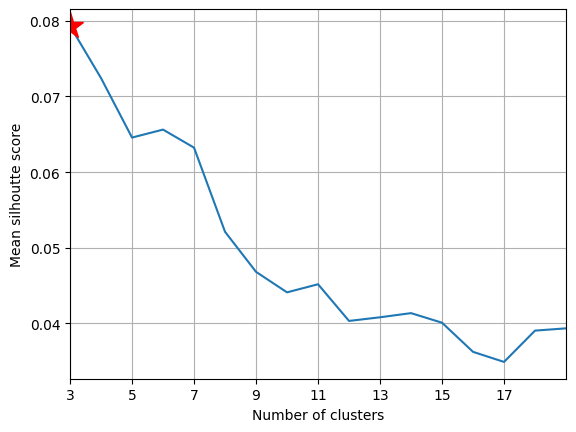

In [28]:
axSS = plt.gca()
axSS.plot(range_n_clusters,avgSils)
axSS.plot(Kopt,avgSils[Kopt-min_num_cluster],'r*',ms=20)
axSS.set_xlabel('Number of clusters')
axSS.set_ylabel('Mean silhoutte score')
axSS.set_xticks(range(min(range_n_clusters),max(range_n_clusters),2));

# axSS.set_ylim(.1,.4)
axSS.set_xlim(min(range_n_clusters),max(range_n_clusters))

axSS.grid()
    


# Plot clusters over time (2012-2014)


We now compare the clusters from our fit to the results from the reference above. The following code plots the frequency of earthquakes in each cluster over time.

# Define colormap

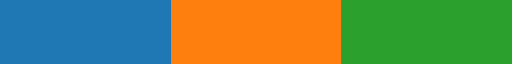

In [29]:

# List of 12 distinct colors
colors_all = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',  '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#FF5733', '#33FF57']  # Add more colors as needed

# Create a ListedColormap object
cmap1 = ListedColormap(colors_all[:Kopt])
cmap1


# Plot event locations by cluster

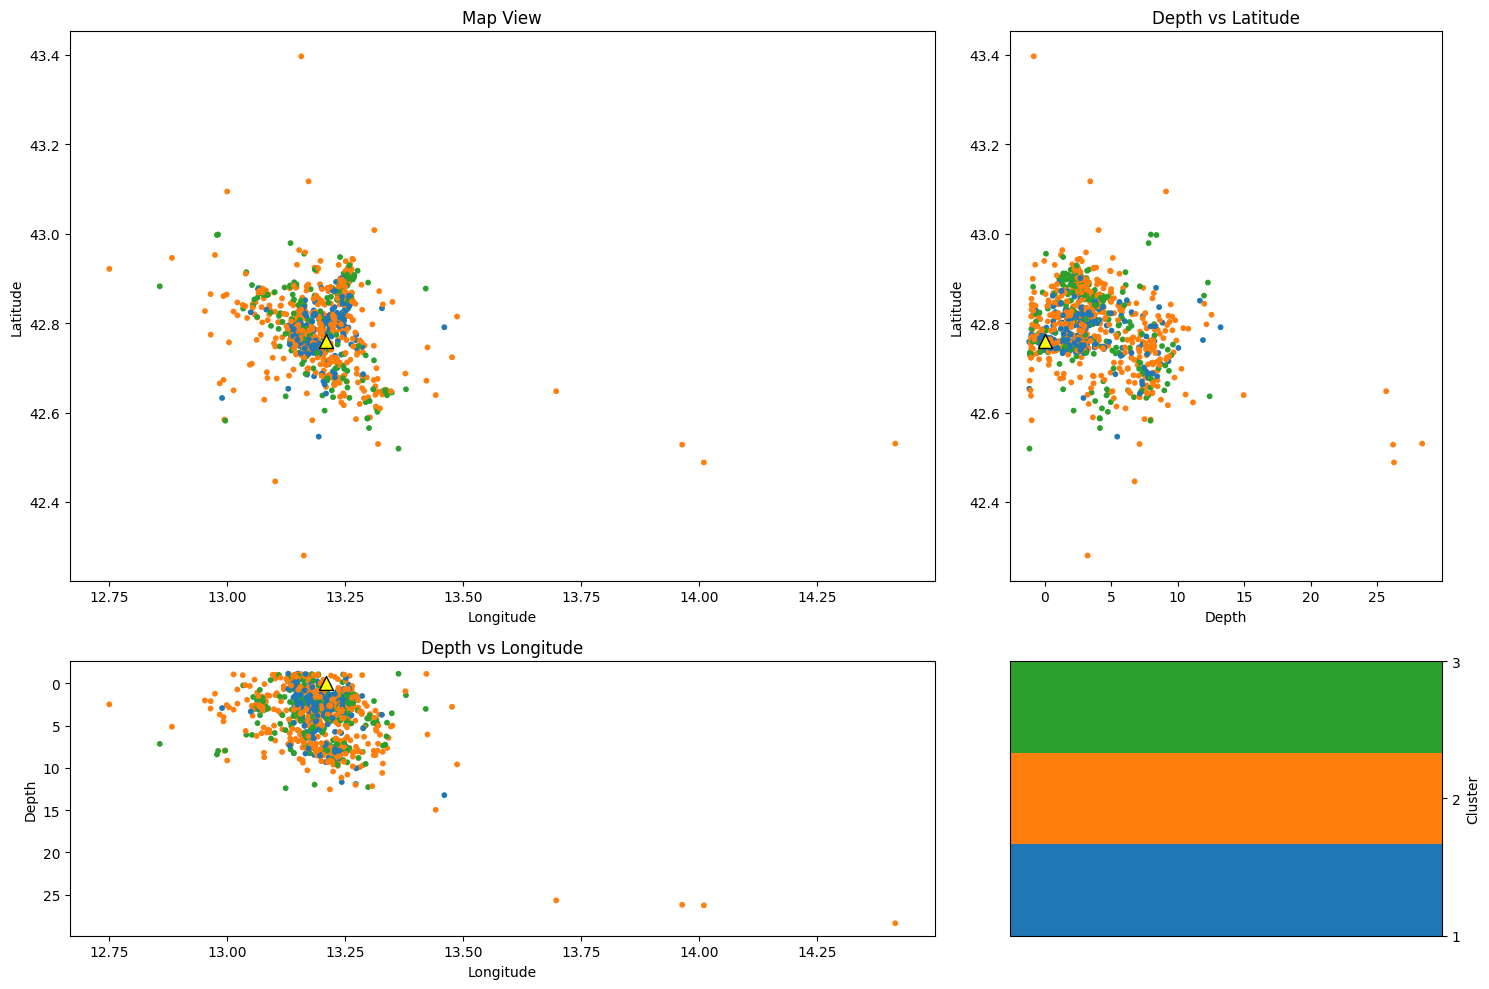

In [30]:

depth = cat["depth"].values
lon = cat["lon"].values
lat = cat["lat"].values
cluster = cat["cluster"].values

# Create a figure and a grid layout
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])


# Map view
ax1 = plt.subplot(gs[0])
im1 = ax1.scatter(lon, lat, c=cluster, cmap=cmap1, s=10)
ax1.scatter(station_lon, station_lat, color='yellow', s=100, edgecolor='k', marker='^')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Map View')

# Depth vs Latitude
ax2 = plt.subplot(gs[1])
im2 = ax2.scatter( depth,lat,c=cluster, cmap=cmap1, s=10)
ax2.scatter(0,station_lat, color='yellow', s=100, edgecolor='k', marker='^')
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Depth')
ax2.set_title('Depth vs Latitude')

# Depth vs Longitude
ax3 = plt.subplot(gs[2])
im3 = ax3.scatter(lon, depth, c=cluster, cmap=cmap1, s=10)
ax3.scatter(station_lon, 0, color='yellow', s=100, edgecolor='k', marker='^')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Depth')
ax3.set_title('Depth vs Longitude')
ax3.invert_yaxis()


cbar_ax1= plt.subplot(gs[3])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
cbar1.set_label('Cluster')
cbar1.set_ticks(np.arange(1, Kopt+1))  # Set colorbar ticks to integers 1 through 4

plt.tight_layout()
plt.show()


<div class="alert-success">
    
    
# Plot specific clusters


#### Example 1. Remove Cluster 2 

```nc = 2 ``` 
    
```cat_2 = cat[(cat.cluster!=nc)] ```
   
    

#### Example 2. Remove Cluster 2 and cluster 3

```nc1 = 2 ``` 
    
```nc1 = 3 ``` 
    
```cat_2 = cat[(cat.cluster!=nc1) and (cat.cluster!=nc2)] ```
        
    
#### Example 3. Analyze ONLY Cluster 2 

```nc = 2 ``` 
    
```cat_2 = cat[(cat.cluster==nc)] ```
    
    
</div>    




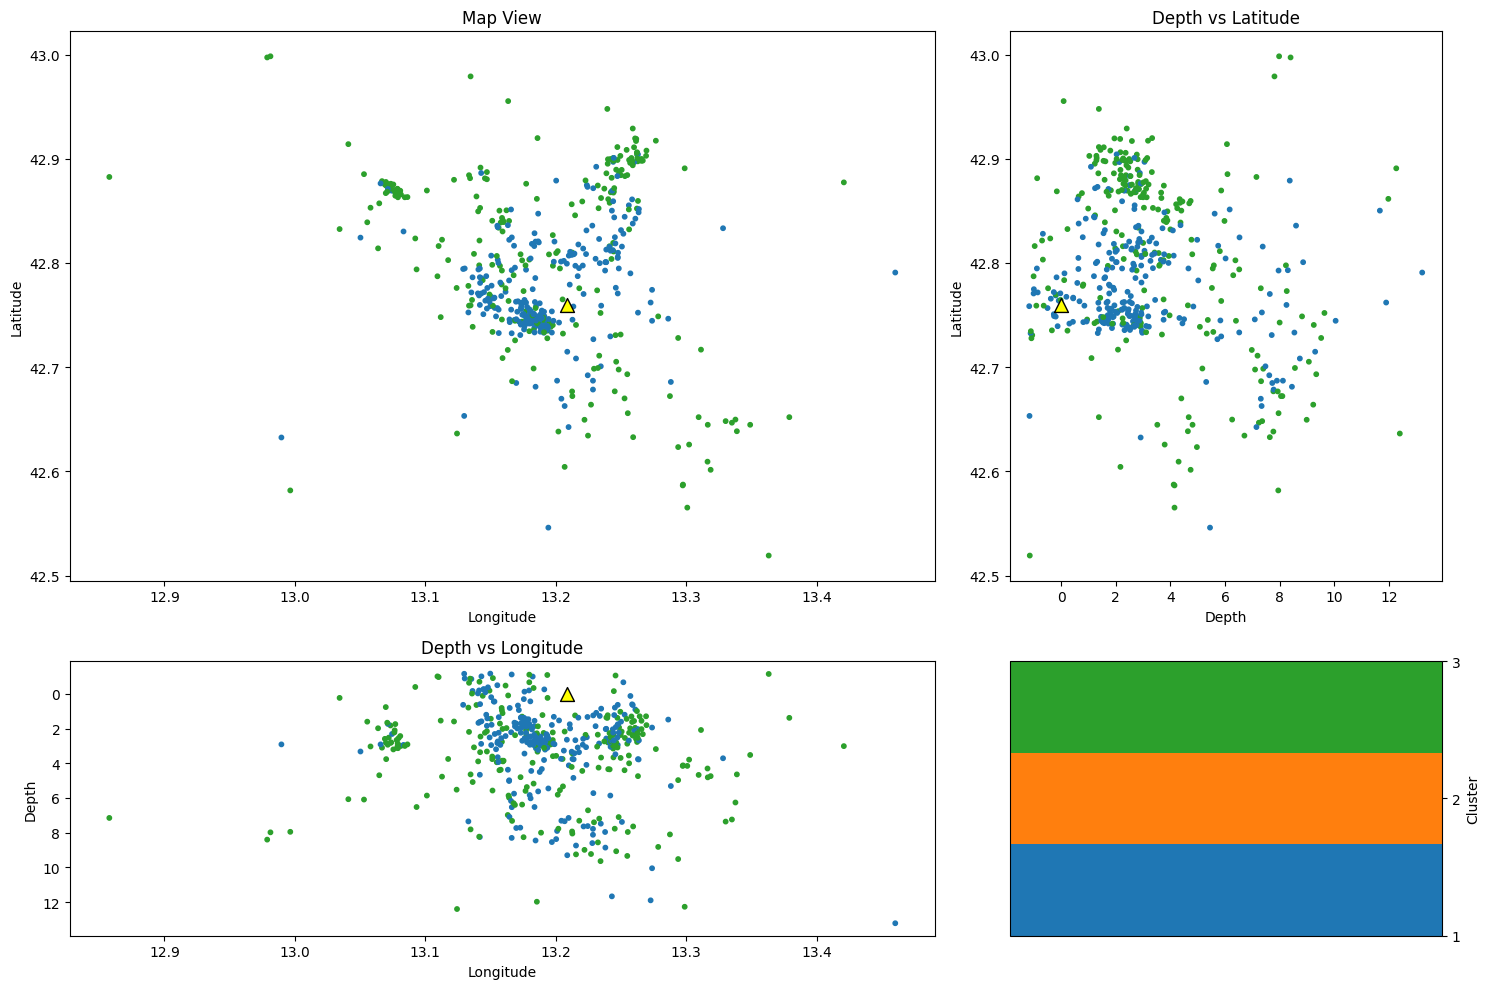

In [40]:
## Remove this cluster from plotting next map figure
nc = 2
cat_2 = cat[(cat.cluster!=nc)]

########################################################################
## don't edit below this line
########################################################################

depth = cat_2["depth"].values
lon = cat_2["lon"].values
lat = cat_2["lat"].values
cluster = cat_2["cluster"].values


# Create a figure and a grid layout
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])


# Map view
ax1 = plt.subplot(gs[0])
im1 = ax1.scatter(lon, lat, c=cluster, cmap=cmap1, s=10)
ax1.scatter(station_lon, station_lat, color='yellow', s=100, edgecolor='k', marker='^')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Map View')

# Depth vs Latitude
ax2 = plt.subplot(gs[1])
im2 = ax2.scatter( depth,lat,c=cluster, cmap=cmap1, s=10)
ax2.scatter(0,station_lat, color='yellow', s=100, edgecolor='k', marker='^')
ax2.set_ylabel('Latitude')
ax2.set_xlabel('Depth')
ax2.set_title('Depth vs Latitude')

# Depth vs Longitude
ax3 = plt.subplot(gs[2])
im3 = ax3.scatter(lon, depth, c=cluster, cmap=cmap1, s=10)
ax3.scatter(station_lon, 0, color='yellow', s=100, edgecolor='k', marker='^')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Depth')
ax3.set_title('Depth vs Longitude')
ax3.invert_yaxis()


cbar_ax1= plt.subplot(gs[3])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
cbar1.set_label('Cluster')
cbar1.set_ticks(np.arange(1, Kopt+1))  # Set colorbar ticks to integers 1 through 4


plt.tight_layout()
plt.show()


# The next cells plot different aspects of the clustered data, including their best-clustered members (those with highest silhouette scores) as waveforms and spectrograms, and cluster depth and magnitude statistics. 

### Plot spectrogram examples

The number of examples (```numEx```) was set earlier in the notebook

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.81it/s]


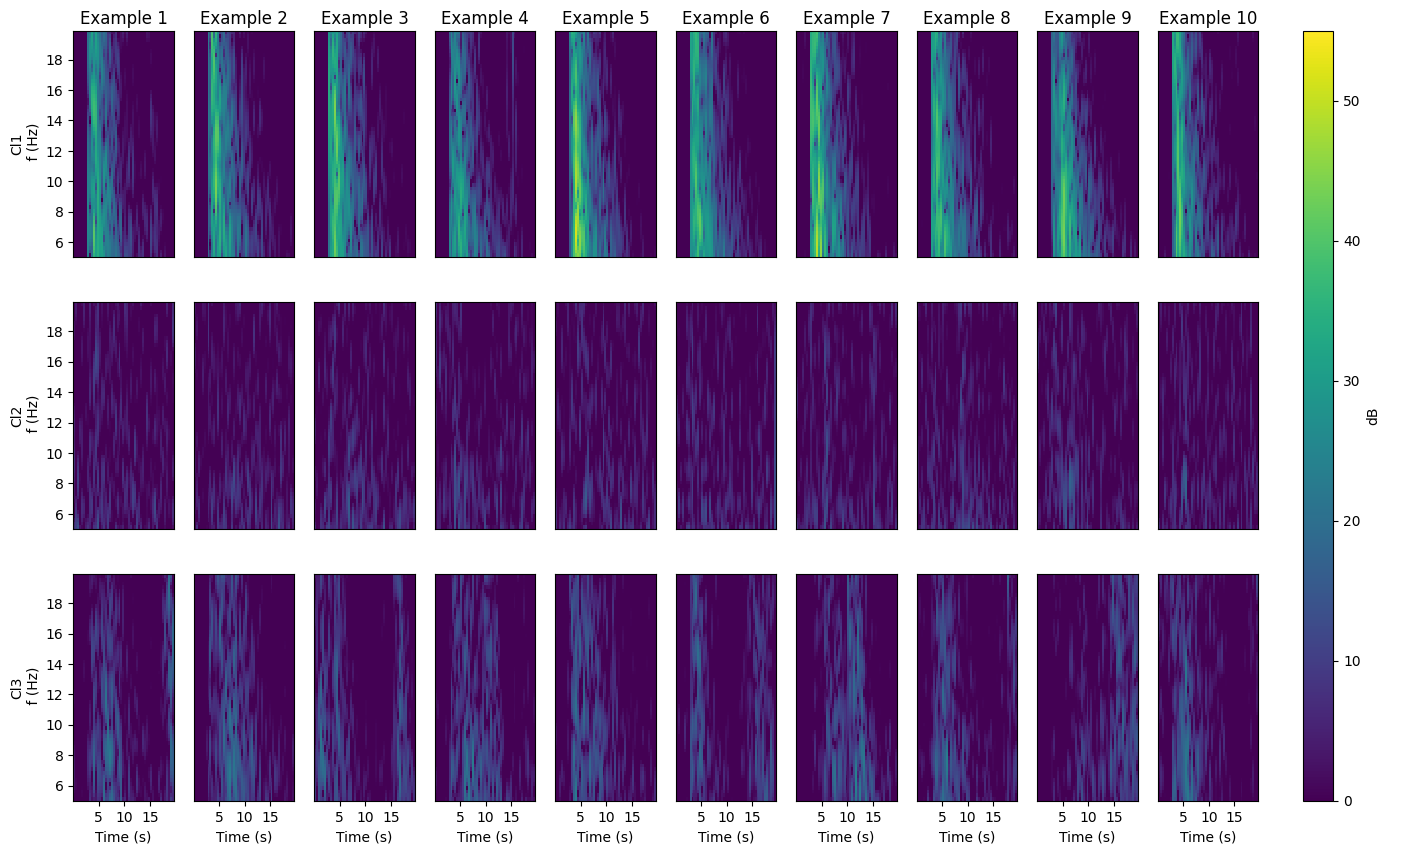

In [31]:

fig = plt.figure(figsize=(15,10))




gs = GridSpec(nrows=Kopt, ncols=numEx, left=0.1, right=0.89)#, width_ratios=[1, 2], height_ratios=[4, 1])
gs2 = GridSpec(nrows=1, ncols=1, left=0.92, right=.94, hspace=0.05)#, width_ratios=[1, 2], height_ratios=[4, 1])


## get sgram freqs and time vectors
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    
    frequencies = fileLoad['spectrograms/fSTFT'][()]
    times =       fileLoad['spectrograms/tSTFT'][()]

    
    
for cl in range(1,Kopt+1):
    
    cat_k = cat[cat.cluster==cl].copy()
    cat_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    for i in tqdm.tqdm(range(numEx)):
        
#         ax = axes[cl-1][i]
        ax = fig.add_subplot(gs[cl-1,i])
        
        indd = cat_k.index[i]
        
        tSTFT, fSTFT, sgram = getSgram(cat.event_ID[indd], SpecUFEx_H5_path)
        im = ax.pcolormesh(tSTFT,
                            fSTFT,
                            sgram,
                            cmap=plt.cm.viridis,
                            shading='auto',vmin=0,vmax=55)

        ax.text(len(tSTFT)-12,.8*np.max(fSTFT),f"Ml{cat_k.mag.iloc[i]}",color='white')
        

           
            
#         if i==numEx//2:
        ax.set_xlabel('Time (s)')
            
        if i ==0:
            ax.set_ylabel('Cl' + str(cl) + '\n f (Hz)') 
            
        if cl!=Kopt:
            ax.set_xlabel('')
            ax.set_xticklabels([])           
            ax.set_xticks([])        
        
        if i!=0:
            ax.set_yticks([])
            ax.set_yticklabels([])


            
        if cl==1:    
            ax.set_title('Example ' + str(i+1),pad=5)#,fontsize=12)     

    

axcbar = fig.add_subplot(gs2[:])
cbar = plt.colorbar(im, cax=axcbar,label='dB')




# plt.savefig(pathFig + "3_" +key + "_clusterExamples_clusOnFP.png", bbox_to_inches='tight',dpi=300)
# plt.close()


### Plot waveform examples

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 83.21it/s]


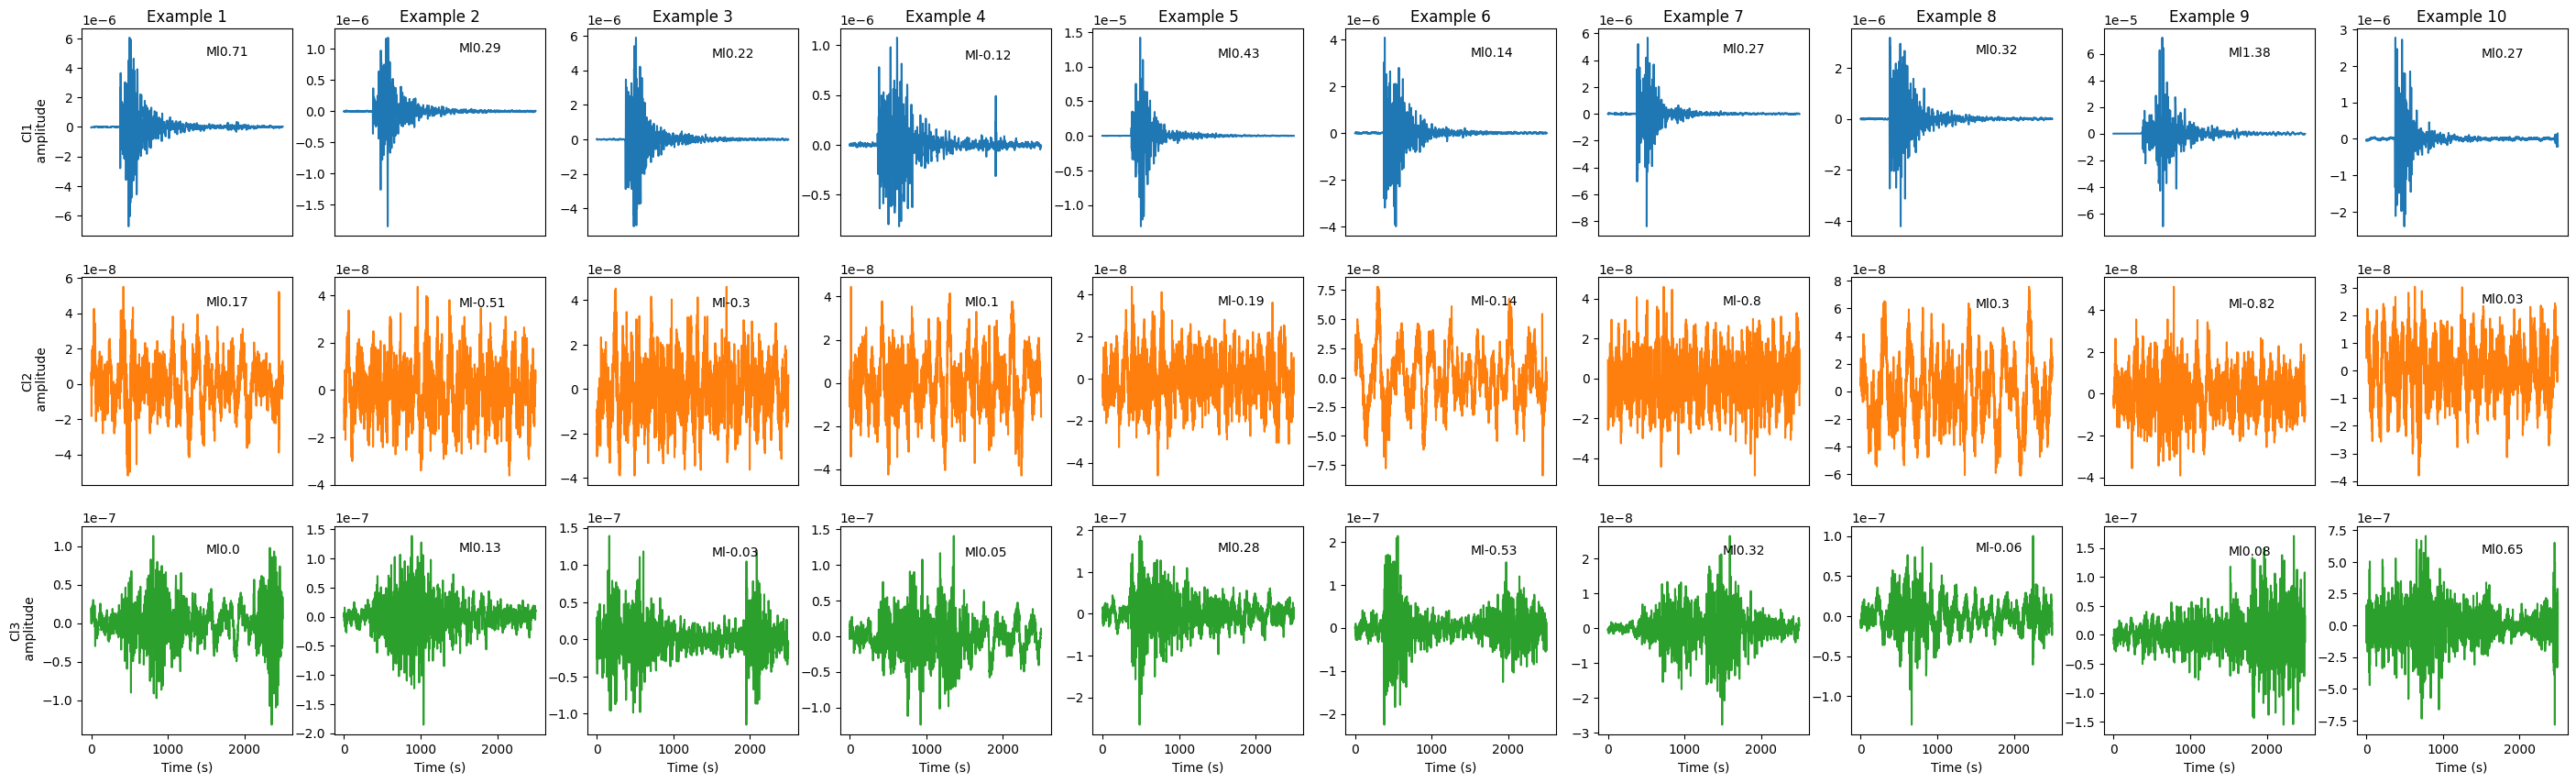

In [39]:


fig = plt.figure(figsize=(35,10))

gs = GridSpec(nrows=Kopt, ncols=numEx)#, width_ratios=[1, 2], height_ratios=[4, 1])


    
    
for cl in range(1,Kopt+1):
    
    cat_k = cat[cat.cluster==cl].copy()
    cat_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    for i in tqdm.tqdm(range(numEx)):
        
#         ax = axes[cl-1][i]
        ax = fig.add_subplot(gs[cl-1,i])
        
        indd = cat_k.index[i]
        
        ax.plot(cat_k.waveform.iloc[i],color=colors_all[cl-1])
        ax.text(len_data-1000,.8*np.max(cat_k.waveform.iloc[i]),f"Ml{cat_k.mag.iloc[i]}")
#         if i==numEx//2:
        ax.set_xlabel('Time (s)')
            
        if i ==0:
            ax.set_ylabel('Cl' + str(cl) + '\n amplitude') 
            
        if cl!=Kopt:
            ax.set_xlabel('')
            ax.set_xticklabels([])           
            ax.set_xticks([])        
        
        # if i!=0:
        #     ax.set_yticks([])
        #     ax.set_yticklabels([])


            
        if cl==1:    
            ax.set_title('Example ' + str(i+1),pad=5)#,fontsize=12)     

    





# plt.savefig(pathFig + "3_" +key + "_clusterExamples_clusOnFP.png", bbox_to_inches='tight',dpi=300)
# plt.close()


### Magnitude Boxplot by cluster

<Figure size 1600x600 with 0 Axes>

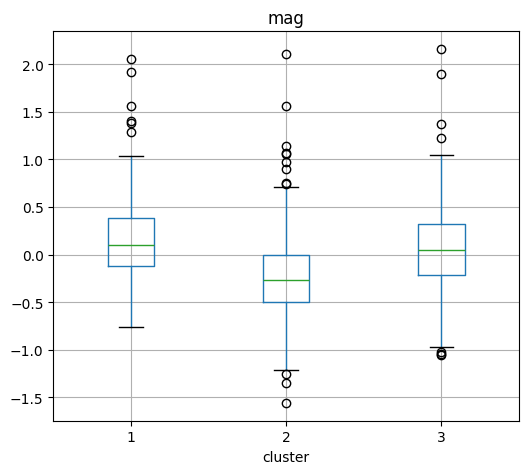

In [33]:
# Create a boxplot
plt.figure(figsize=(16, 6))
cat.boxplot(column='mag',by='cluster', layout=(1, Kopt), figsize=(15, 5))
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.title('Boxplot of Depth, Latitude, and Longitude by Cluster')
plt.tight_layout()
plt.show()

### Depth Boxplot by cluster

<Figure size 1600x600 with 0 Axes>

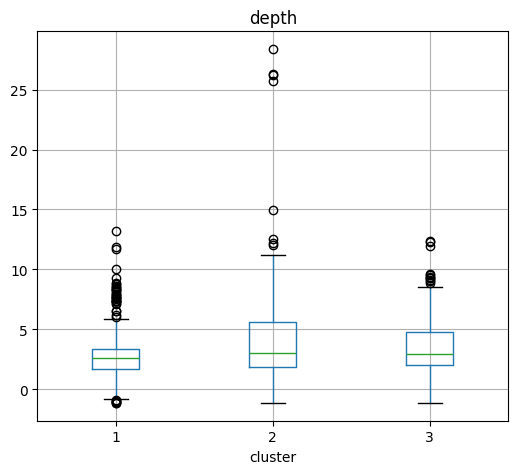

In [34]:
# Create a boxplot
plt.figure(figsize=(16, 6))
cat.boxplot(column='depth',by='cluster', layout=(1, Kopt), figsize=(15, 5))
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.title('Boxplot of Depth, Latitude, and Longitude by Cluster')
plt.tight_layout()
plt.show()

# End of tutorial

